<a href="https://colab.research.google.com/github/saksham-aroraa/stegano/blob/main/stegano1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key based Image Steganography using Convolution layers




1. Importing Libraries

In [1]:
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
from tqdm import *

%matplotlib inline

2. i. downloading dataset in local space

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2022-05-09 03:21:41--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.9MB/s    in 7.3s    

2022-05-09 03:21:48 (32.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

ii. Unzipping the files:

In [4]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

# Preparing for Steganography

3. Preparing Training set and Test set

In [5]:
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

In [6]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    
    X_train = []
    X_test = []

    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    return np.array(X_train), np.array(X_test)

In [7]:
X_train_orig, X_test_orig = load_dataset_small()
X_train = X_train_orig/255.
X_test = X_test_orig/255.

print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) 

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


#Trial: Applying Caeser's cipher

In [8]:
def caeser_cipher(img, key=1):
  img = img*255
  img = img + key
  img[img>255] = img[img>255]%255 - 1
  return img/255.

In [9]:
def caeser_rev(img, key=1):
  img = img*255.
  img = img - key
  img[img<0] = img[img<0] + 256
  return img/255.

In [10]:
def imgshowvs(first, second):
  fig=plt.figure(figsize=(4, 4))
  fig.add_subplot(1, 2, 1)
  plt.imshow(first)
  fig.add_subplot(1, 2, 2)
  plt.imshow(second)
  plt.show()

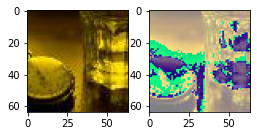

In [11]:
#caeser cipher's trial
idx = 443
fact = X_train[idx].flatten()
seed = 127
demo_caeser = np.copy(X_train[idx])
cipher_img = caeser_cipher(demo_caeser, seed)
imgshowvs(demo_caeser, cipher_img)

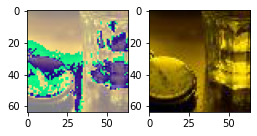

In [12]:
#retrieve 
imgshowvs(cipher_img, caeser_rev(cipher_img, seed))

**Inference**:
If the intruder somehow recovered the distorted image, the intruder can take a guess at Caeser's cipher, or at least can claim it as some sort of filter. Therefore, this method is not good enough.

# Trial: randomization of pixel values

In [13]:
def distort(ls, seed):
  shap = ls.shape
  ls = ls.flatten()
  random.seed(seed)
  random.shuffle(ls)
  return np.array(ls.reshape(shap))

In [14]:
def recover(shuffled_ls, seed):
  shap = shuffled_ls.shape
  shuffled_ls = shuffled_ls.flatten()
  n = len(shuffled_ls)
  perm = [i for i in range(1, n + 1)]
  random.seed(seed)
  random.shuffle(perm)
  zipped_ls = list(zip(shuffled_ls, perm))
  zipped_ls.sort(key=lambda x: x[1])
  unshuffled = [a for (a, b) in zipped_ls]
  return np.array([unshuffled]).reshape(shap)

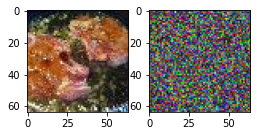

In [15]:
import math
#secret to distorted image conversion trial
demo = 850
initial = np.copy(X_train[demo])
seed = math.factorial(X_train[0].flatten().shape[0])-200 #this seed is 44918 digits long
initial_distorted = distort(initial, seed)

imgshowvs(X_train[demo], distort(initial, seed))

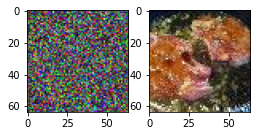

In [16]:
#distorted to original image trial
imgshowvs(initial_distorted, recover(initial_distorted, seed))

**Inference:**
With the randomization cryptography algorithm, even if the intruder happened to recover the file with a certain revealing network, he will be able to recover the distorted image. This might lead to closure of the intrusion, and even if it doesn't, it will take an enormous amount of effort to get the original image back.

**Sample Images from dataset:**

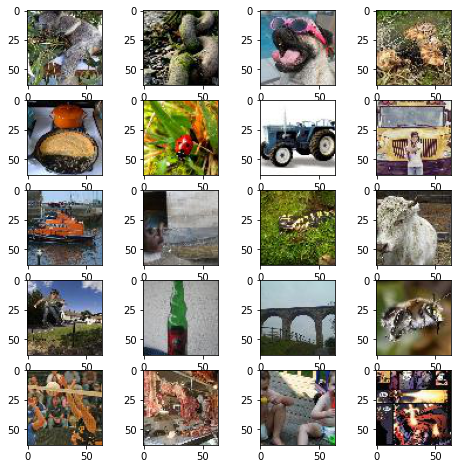

In [17]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
choices = []
for i in range(1, columns*rows +1):
    img_idx = np.random.choice(X_train.shape[0]//2)
    choices.append(img_idx)
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [18]:
input_S = np.copy(X_train[0:X_train.shape[0] // 2])
S_safe = np.copy(input_S)
input_C = np.copy(X_train[X_train.shape[0] // 2:])

In [19]:
for i in range(input_S.shape[0]):
  input_S[i] = distort(input_S[i],seed)

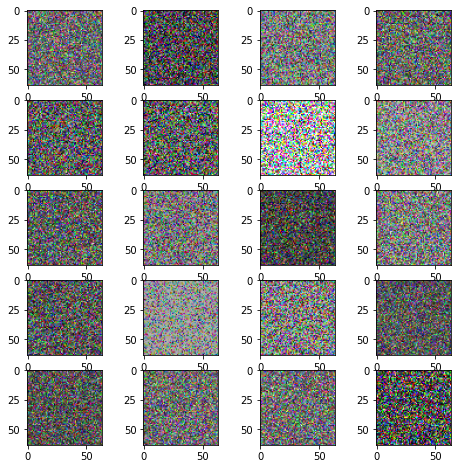

In [20]:
fig=plt.figure(figsize=(8, 8))
inc = 0
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(input_S[choices[inc]])
    inc+=1
plt.show()

In [21]:
beta = 1.0
# loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

#loss for the full model, which has been used for preparation and hiding networks
def full_loss(y_true, y_pred):
    # Loss for the full model: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[:,:,:,0:3], y_true[:,:,:,3:6]
    s_pred, c_pred = y_pred[:,:,:,0:3], y_pred[:,:,:,3:6]
    
    s_loss = beta * K.sum(K.square(s_true - s_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss

In [22]:
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(input_S)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(input_S)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')
    
def make_decoder(input_size, fixed=False):
    # The variable declared below will store the Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Here we are adding Gaussian noise with 0.01 standard deviation for better training accuracy
    input_with_noise = GaussianNoise(0.01)(reveal_input)
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(input_with_noise)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(input_with_noise)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), padding='same', activation='relu')(x)
    x4 = Conv2D(10, (4, 4), padding='same', activation='relu')(x)
    x5 = Conv2D(5, (5, 5), padding='same', activation='relu')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), padding='same', activation='relu', name='output_S')(x)
    
    return Model(inputs=reveal_input,
                 outputs=output_Sprime,
                 name = 'Decoder')
    
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder

In [23]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

In [24]:
NB_EPOCHS = 60
BATCH_SIZE = 32

m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    
    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss = []
    for idx in t:
        
        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss.append(reveal_model.train_on_batch(x=C_prime, y=batch_S))

        K.set_value(autoencoder_model.optimizer.lr, 0.001)
        K.set_value(reveal_model.optimizer.lr, 0.001)
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
    loss_history.append(np.mean(ae_loss))

Epoch 1 | Batch: 992 of 1000. Loss AE   98229.08 | Loss Rev   65405.30: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]
Epoch 2 | Batch: 992 of 1000. Loss AE   42475.75 | Loss Rev   31734.71: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
Epoch 3 | Batch: 992 of 1000. Loss AE   33882.72 | Loss Rev   26525.42: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
Epoch 4 | Batch: 992 of 1000. Loss AE   31340.06 | Loss Rev   25459.93: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
Epoch 5 | Batch: 992 of 1000. Loss AE   30822.21 | Loss Rev   25691.94: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s]
Epoch 6 | Batch: 992 of 1000. Loss AE   28967.85 | Loss Rev   25003.93: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s]
Epoch 7 | Batch: 992 of 1000. Loss AE   27784.77 | Loss Rev   24697.28: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
Epoch 8 | Batch: 992 of 1000. Loss AE   28837.80 | Loss Rev   25484.07: 100%|██████████| 32/32 [00:13<00:00,  2.37it/s]
Epoch 9 | Batch: 992 of 1000. Loss AE   

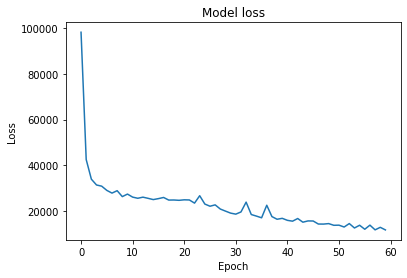

In [25]:
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [26]:
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

In [27]:
recovered_S = []
for i in range(decoded_S.shape[0]):
  recovered_S.append(recover(decoded_S[i], seed))

recovered_S = np.array(recovered_S)
diff_S, diff_C = np.abs(recovered_S - S_safe), np.abs(decoded_C - input_C)

In [28]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_Spixel, see_Cpixel

 # Calculates histograms of errors for cover and secret image.
def pixel_histogram(diff_S, diff_C):
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, density=True,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, density=True,  alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])
    
    plt.show()

In [29]:
# pixel-wise average errors on a 256 scale.
S_error, C_error = pixel_errors(S_safe, input_C, recovered_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 39.83762
C error per pixel [0, 255]: 19.198296


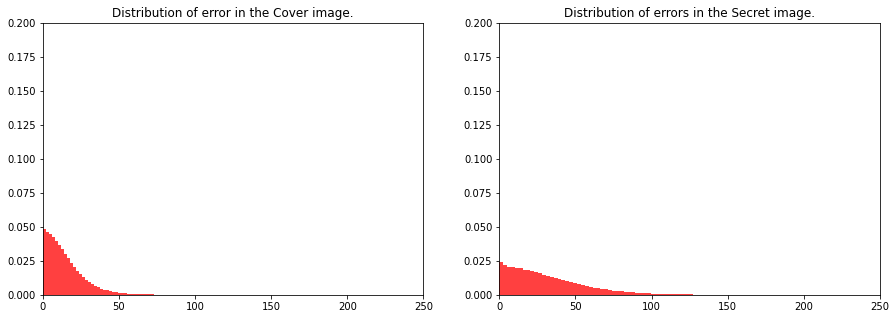

In [30]:
# distribution of errors in cover and secret images.
pixel_histogram(diff_S, diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.7383760344382894
PSNR value is 69.88160958394171 dB
MSE value is 0.020046597456716202
SSIM value is 0.7135631649913771
PSNR value is 71.35406419625909 dB
MSE value is 0.014282202866346471
SSIM value is 0.7229410758152488
PSNR value is 71.97791989645043 dB
MSE value is 0.012371136590830861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.8618315599799731
PSNR value is 68.92257167494658 dB
MSE value is 0.02500025560973585
SSIM value is 0.8758769060193048
PSNR value is 70.34198779585515 dB
MSE value is 0.01803029584782525
SSIM value is 0.8009041026713346
PSNR value is 67.59975094851717 dB
MSE value is 0.033902090966276346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SSIM value is 0.8909776212443772
PSNR value is 70.49575983860521 dB
MSE value is 0.01740306082866585


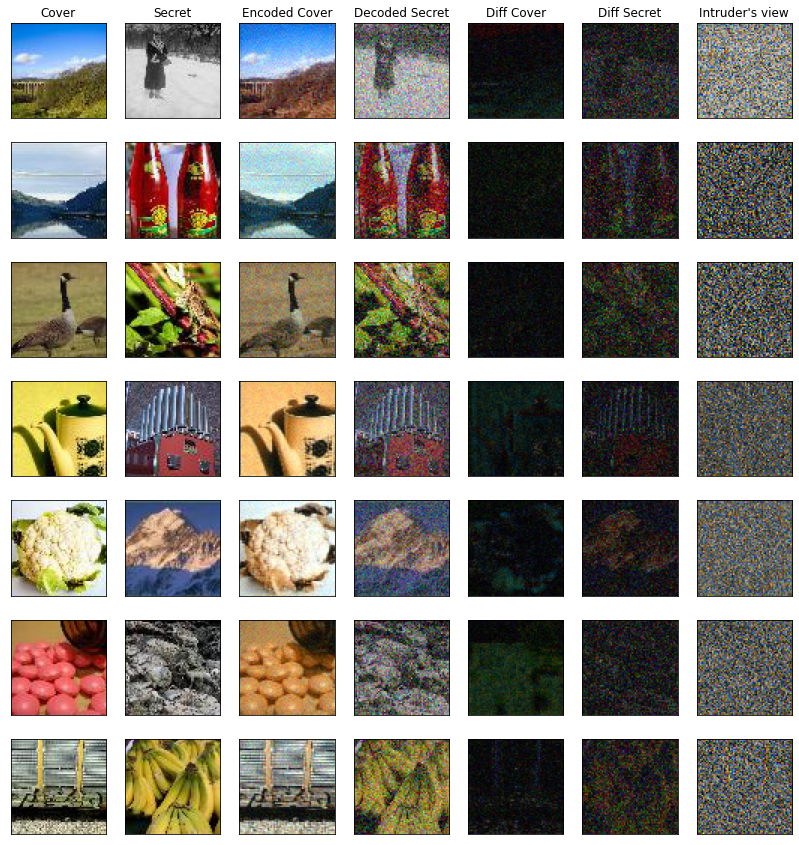

In [31]:
import cv2
from skimage.metrics import structural_similarity as ssim

# Function to evaluate PSNR value
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): 
        return 100
    max_pixel = 255.0
    psnr = 20 * np.math.log10(max_pixel / np.math.sqrt(mse))
    return psnr

# Function to evaluate MSE value
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err


# Here we have declared Diff enhance magnitude
ENHANCE = 1

# The variable n is declared to show the Number of secret and cover pairs.
n = 7

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
for i, idx in enumerate(rand_indx):
    n_col = 7
    
    img_np = np.squeeze(input_C[idx])
    img_np1 = np.squeeze(decoded_C[idx])

    kl = ssim(img_np,img_np1,multichannel=True)
    print(f"SSIM value is {kl}")

    original = input_C[idx]
    compressed = decoded_C[idx]
    value = PSNR(original, compressed)
    print(f"PSNR value is {value} dB")

    value1 = mse(original, compressed)
    print(f"MSE value is {value1}")

    show_image(input_C[idx], n, n_col, i * n_col + 1, first_row=i==0, title='Cover')

    show_image(S_safe[idx], n, n_col, i * n_col + 2, first_row=i==0, title='Secret')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 3, first_row=i==0, title='Encoded Cover')
    
    show_image(recovered_S[idx], n, n_col, i * n_col + 4, first_row=i==0, title='Decoded Secret')

    show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, first_row=i==0, title='Diff Cover')
        
    show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, first_row=i==0, title='Diff Secret')

    show_image(decoded_S[idx], n, n_col, i * n_col + 7, first_row=i==0, title='Intruder\'s view')

plt.show()

In [32]:
s = []
p = []
m = []

for i in range(1000):
  img_np = np.squeeze(input_C[i])
  img_np1 = np.squeeze(decoded_C[i])

  kl = ssim(img_np,img_np1,multichannel=True)
  s.append(kl)

  original = input_C[idx]
  compressed = decoded_C[idx]
  value = PSNR(original, compressed)
  p.append(value)

  value1 = mse(original, compressed)
  m.append(value1)

In [33]:
print(sum(s)/len(s))
print(sum(p)/len(p))
print(sum(m)/len(m))

0.8286681504489234
70.49575983860456
0.01740306082866607


0.6930340733574222

68.47042572379885

0.02774335848215787